In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/'Applied CV Project'/extended-fruits-360_dataset

/content/drive/.shortcut-targets-by-id/1i0IgUBpr8uyXxhLQgE5RaQK7Qf6agpOh/Applied CV Project/extended-fruits-360_dataset


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0drzix62
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0drzix62
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
ls

AdditionalFoodItems/  best_additional_deit.pth  extended-fruits-360/  extended-fruits-360.zip


In [ ]:
!mkdir -p ~/.data
!cp "extended-fruits-360.zip" ~/.data/
!chmod 600 ~/.data/"extended-fruits-360.zip"
!ls ~/.data

extended-fruits-360.zip


In [ ]:
import os, shutil
import zipfile

zip_file_path = './extended-fruits-360.zip'
assert os.path.exists(zip_file_path)

# extract all files to /tmp
print('Source zip: %s' % zip_file_path)
print('Extracting all images...', end='', flush=True)
zip_ref = zipfile.ZipFile(zip_file_path, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()
print('done!', flush=True)

Source zip: ./extended-fruits-360.zip
Extracting all images...done!


In [ ]:
!ls '/tmp/fruits-360'

 LICENSE	  readme.md		    Test_data.json	   Training_data_april_11.json
'Original Size'   Test			    test-multiple_fruits   Training_data.json
 papers		  Test_data_april_11.json   Training		   Training_data_updated.json


In [ ]:
import json
from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

In [ ]:
# Choose computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load pre-trained CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def get_fruit_categories(folder_root):
    """
    Get the fruit categories from the provided folder root.

    Args:
    - folder_root (str): The root folder containing the fruit categories.

    Returns:
    - fruit_categories (dict): A dictionary mapping category indices to category names.
    """
    fruit_category_names = sorted(os.listdir(folder_root))
    fruit_categories = {i: name for i, name in enumerate(fruit_category_names)}
    return fruit_categories

In [ ]:
# Specify folder roots
train_folder_root = '/tmp/fruits-360/Training'
test_folder_root = '/tmp/fruits-360/Test'

train_classes = get_fruit_categories(train_folder_root)
val_classes = get_fruit_categories(test_folder_root)

In [ ]:
# Check if both dictionaries have the same keys
if train_classes.keys() != val_classes.keys():
    print("The dictionaries have different keys:")
    print("Keys in train_classes:", train_classes.keys())
    print("Keys in val_classes:", val_classes.keys())
else:
    print("The dictionaries have the same keys.")

# Check if the values for each key are the same
differences = {}
for key in train_classes:
    if train_classes[key] != val_classes[key]:
        differences[key] = (train_classes[key], val_classes[key])

if differences:
    print("\nKey-value mappings with differences:")
    for key, (train_value, val_value) in differences.items():
        print(f"Key: {key}, train_value: {train_value}, val_value: {val_value}")
else:
    print("\nBoth dictionaries have identical key-value mappings.")

The dictionaries have the same keys.

Both dictionaries have identical key-value mappings.


In [ ]:
assert(len(train_classes.keys()) == len(val_classes.keys()))
NUM_CLASSES = len(train_classes.keys())
print('Detected %d classes' % NUM_CLASSES)

Detected 143 classes


In [ ]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 2.2.1+cu121 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


In [ ]:
# Scale all images to same size, convert them to tensors, and normalize data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = ImageFolder(train_folder_root, train_transforms)
val_dataset = ImageFolder(test_folder_root, val_transforms)

print("No of training records: %d" % len(train_dataset))
print("No of test records: %d" % len(val_dataset))

No of training records: 69167
No of test records: 23015


In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

print(len(train_loader))
print(len(val_loader))

1081
360


In [ ]:
from PIL import ImageOps

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        # Convert image to RGB color space if it's not already in RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize the image to match the grid cell size (optional)
        img = ImageOps.fit(img, (w, h), method=Image.LANCZOS)

        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In [ ]:
first_batch = next(iter(train_loader))

# Get the first 6 images from the batch
samples = first_batch[0][:6]  # Assuming the images are at index 0 in the batch

# Convert the PyTorch tensors to PIL images
images = [Image.fromarray(image.permute(1, 2, 0).numpy().astype('uint8')) for image in samples]

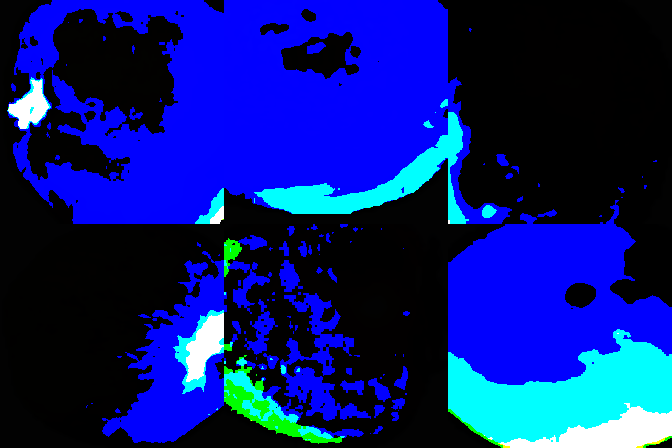

In [ ]:
grid = image_grid(images, cols=3)
display(grid)

In [ ]:
classes = list(train_classes.values())
inputs = processor(text=classes, images=images, return_tensors="pt", padding=True)

In [ ]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

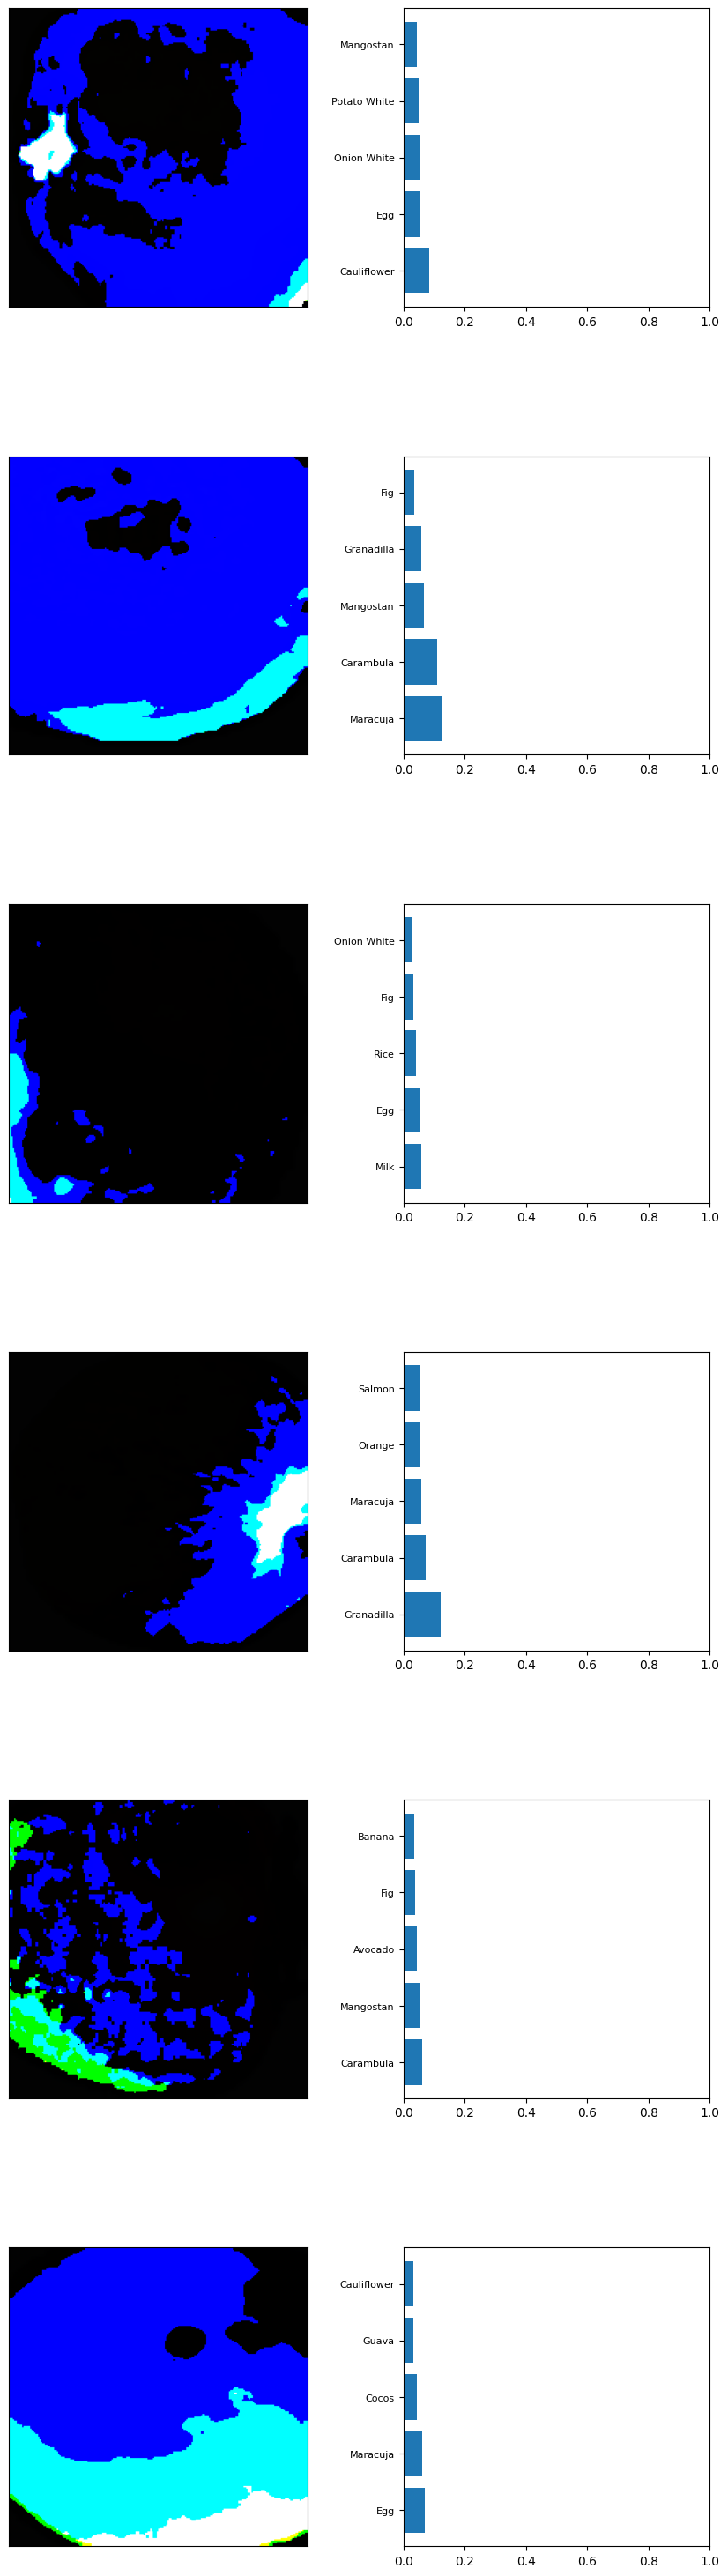

In [ ]:
fig = plt.figure(figsize=(10, 6 * len(images)))  # Adjust figure height based on the number of images

for idx in range(len(images)):
    # Get the top 5 most probable classes and their probabilities
    top5_probs, top5_indices = torch.topk(probs[idx], k=5)
    top5_classes = [classes[i] for i in top5_indices]

    # show original image
    ax1 = fig.add_subplot(len(images), 2, 2 * (idx + 1) - 1)
    ax1.imshow(images[idx])
    ax1.set_xticks([])
    ax1.set_yticks([])

    # show probabilities
    ax2 = fig.add_subplot(len(images), 2, 2 * (idx + 1))
    ax2.barh(range(len(top5_probs)), top5_probs.detach().numpy(), tick_label=top5_classes)
    ax2.set_xlim(0, 1.0)
    ax2.set_yticklabels(top5_classes)  # Set y-axis tick labels to the top 5 class names
    ax2.tick_params(axis='y', which='major', labelsize=8)  # Adjust y-axis tick label font size

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.5)  # Adjust spacing between subplots
plt.show()